# Markowitz Portfolio's Theory #

### Building the Efficient Frontier ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optimization
from scipy.optimize import minimize

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data

# Pretty Notation
from IPython.display import display, Math

In [2]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

In [9]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['adj_close']
df_data['AMZN'] = df_2['adj_close']
df_data['META'] = df_3['adj_close']
df_data['MSFT'] = df_4['adj_close']

# Drop Nans
df_data = df_data.dropna()

# Create the returns
df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT
Date,,,,
2015-01-02,0.103109,0.122536,0.109293,0.104190
2015-01-05,-2.817159,-2.051731,-1.606119,-0.930282
2015-01-06,0.009412,-2.283332,-1.347325,-1.457097
2015-01-07,1.402221,1.059975,0.000000,1.270537
2015-01-08,3.842227,0.683600,2.659225,2.941813
...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686
2024-10-24,-0.082337,0.904120,0.725576,0.030617


In [10]:
# Theoretically we could use the average as the expected returns (these are daily returns)
expected_returns = df_returns.mean()
expected_returns.name = 'mean_returns'

expected_returns

AAPL    0.103109
AMZN    0.122536
META    0.109293
MSFT    0.104190
Name: mean_returns, dtype: float64

In [11]:
# The volatility is calculated with the standard deviations (also daily volatilities)

volatility = df_returns.dropna().std()
volatility.name = 'volatility'

volatility

AAPL    1.804141
AMZN    2.064870
META    2.370595
MSFT    1.714066
Name: volatility, dtype: float64

In [12]:
# Covariance Matrix

cov_matrix = df_returns.dropna().cov()

cov_matrix

,AAPL,AMZN,META,MSFT
AAPL,3.254923,2.072320,2.253791,2.113185
AMZN,2.072320,4.263688,2.893688,2.324754
META,2.253791,2.893688,5.619722,2.365815
MSFT,2.113185,2.324754,2.365815,2.938023


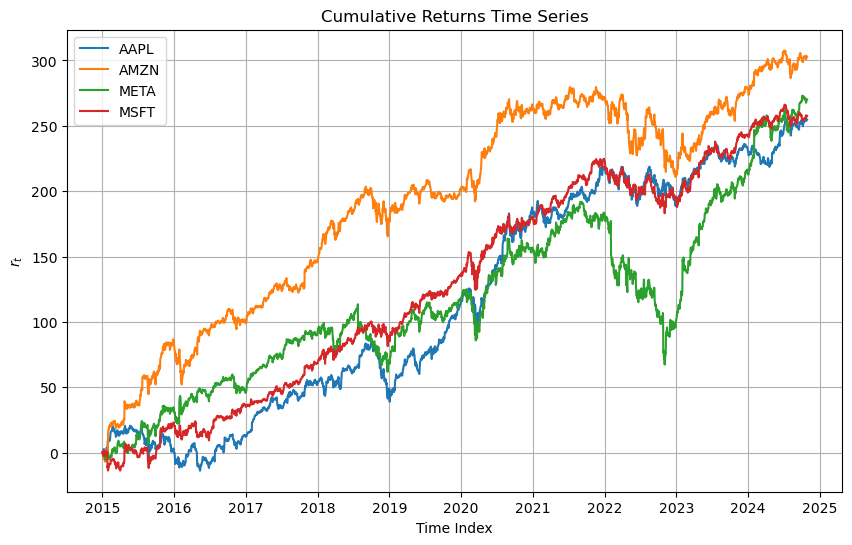

In [15]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('$r_t$')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [16]:
# The Markowitz's Theory establish that a portfolio's returns and variance are defined by the following equations

display(Math(r"\mu_{P} = \sum_{i=1}^{n}{\omega_i\mu_i}"))
display(Math(r"\sigma_P^2=\sum_{i=1}^{n}\sum_{j=1}^n{\omega_i\omega_j\gamma_ij}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
# To create random portfolios first we need to create random weights

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

rand_weights(4)

array([0.20350568, 0.22016932, 0.30709682, 0.26922817])

In [22]:
### This function create a random portfolio based on random weights

def random_portfolio(expected_returns, cov_matrix):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    # Generate Random Weights
    weights = rand_weights(len(expected_returns))
    
    # Calculate the Portfolio's Returns
    portfolio_returns = np.dot(weights, expected_returns)
    
    # Calculate the Portfolio's Risk
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_stddev = np.sqrt(portfolio_variance)
    
    return portfolio_returns, portfolio_stddev

returns_i, risk_i = random_portfolio(expected_returns, cov_matrix)

print(f"The Random Portfolio's Return is: {returns_i.round(3)}")
print(f"The Random Portfolio's Volatility is: {risk_i.round(3)}")

The Random Portfolio's Return is: 0.108
The Random Portfolio's Volatility is: 1.6


In [23]:
# We can use this function to generate several random portfolios

def generate_random_portfolios(n_portfolios, expected_returns, cov_matrix):

    # Lists to store the portfolios' information
    means = []
    stds = []

    # Generate the portfolios
    for _ in range(n_portfolios):
        mean, std = random_portfolio(expected_returns.values.flatten(), cov_matrix)
        means.append(mean)
        stds.append(std)
    
    # Store them in a DataFrame
    portfolios = pd.DataFrame({
        'Mean Return': means,
        'Std Dev': stds
    })
    
    return portfolios

n_portfolios = 1000
portfolios = generate_random_portfolios(n_portfolios, expected_returns, cov_matrix)

portfolios

,Mean Return,Std Dev
0,0.108636,1.697948
1,0.107209,1.646355
2,0.109614,1.690292
3,0.108650,1.675316
4,0.106444,1.644520
...,...,...
995,0.113102,1.730519
996,0.117807,1.860997
997,0.107186,1.747269
998,0.111238,1.703192


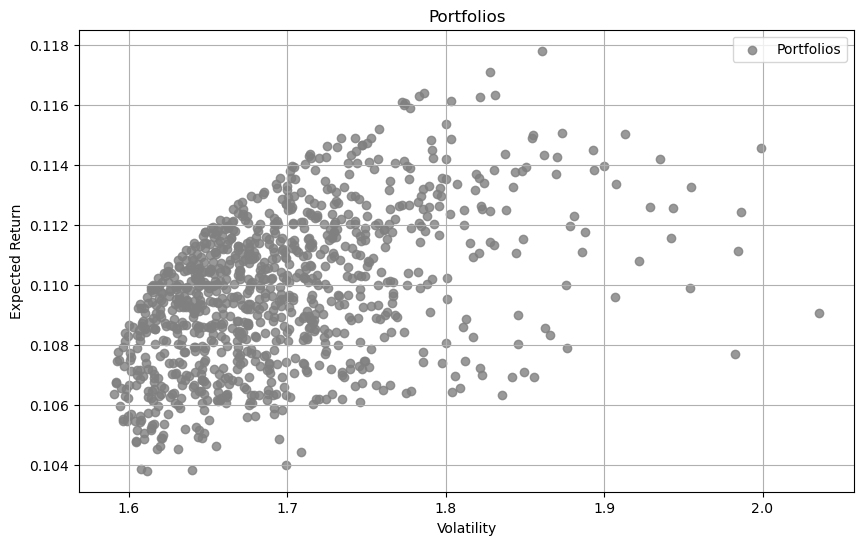

In [24]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.8, label='Portfolios')

# Config
plt.title('Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [25]:
# We can create the Equal-Weighted Portfolio to compare it with the other portfolios
def equal_weighted_portfolio(expected_returns, cov_matrix):
    
    # Generate the Equal Weights
    n = len(expected_returns)
    weights = np.ones(n) / n  

    # Calculate the Portfolio's Returns
    portfolio_return = np.dot(weights, expected_returns)
    
    # Calculate the Portfolio's Risk
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_return, portfolio_volatility

returns_e, risk_e = equal_weighted_portfolio(expected_returns, cov_matrix)

print(f"The Equal-Weighted Portfolio's Return is: {returns_e.round(3)}")
print(f"The Equal-Weighted Portfolio's Volatility is: {risk_e.round(3)}")

The Equal-Weighted Portfolio's Return is: 0.11
The Equal-Weighted Portfolio's Volatility is: 1.661


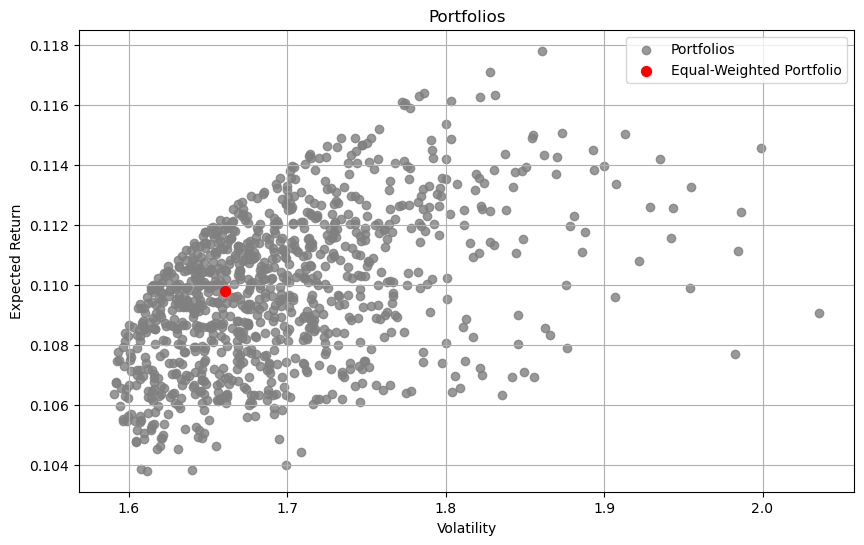

In [26]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.8, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  


# Config
plt.title('Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [31]:
# Now how can we obtain the Efficient Frontier

# Optimization functions
def portfolio_performance(weights, expected_returns, cov_matrix):
    # Portfolio's Returns
    portfolio_return = np.dot(weights, expected_returns)

    #Portfolio's Volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_return, portfolio_volatility
    
# Minimizing Portfolio
def minimize_volatility(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

# Function that generates the portfolios that are located in the Efficient Frontier
def get_efficient_frontier(expected_returns, cov_matrix, num_portfolios=100):
    results = np.zeros((2, num_portfolios))
    target_returns = np.linspace(expected_returns.min(), expected_returns.max(), num_portfolios)
    
    for i, target in enumerate(target_returns):
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},                          # weights must sum one
                       {'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - target})   # portfolio returns
        bounds = tuple((-1, 1) for _ in range(len(expected_returns)))                           # no short if bounds [0,1]
        initial_guess = len(expected_returns) * [1. / len(expected_returns)]
        
        opt = minimize(minimize_volatility, initial_guess, args=(expected_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if opt.success:
            results[0, i] = target
            results[1, i] = opt.fun

    return results

efficient_frontier = get_efficient_frontier(expected_returns, cov_matrix)

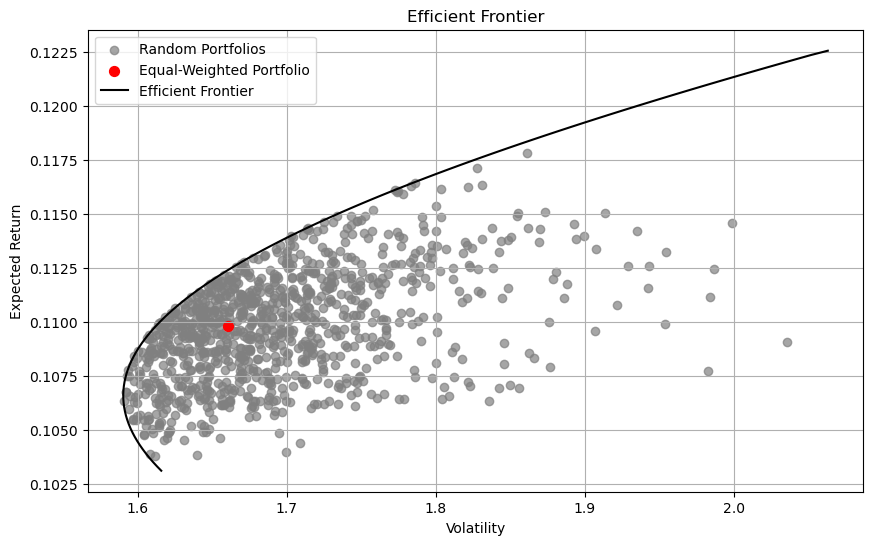

In [32]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.7, label='Random Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(efficient_frontier[1, :], efficient_frontier[0, :], label='Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [33]:
# To find the equation of the efficient frontier we have to solve the optimization problem

display(Math(r"\sigma_P^2 = \pi_0 + \pi_1\mu_P + \pi_2\mu_P^2"))

<IPython.core.display.Math object>

In [34]:
# In the Chapter 3 of Book you can find the next forms

display(Math(r"A = \mu^⊤\Sigma^{-1}\mu"))
display(Math(r"B = \mu^⊤\Sigma^{-1}\iota"))
display(Math(r"C = \iota^⊤\Sigma^{-1}\iota"))
display(Math(r"D = AC-B^2"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [59]:
# So let us obtain the components

n = len(expected_returns)                                   # Number of Stocks
mu = expected_returns.values.flatten().reshape(-1, 1)       # Expected Returns
Sigma = cov_matrix.values                                   # Covariance Matrix
Sigma_inv = np.linalg.inv(Sigma)                            # Inverse Covariance Matrix
iota = np.ones((n, 1))                                      # Vector of Ones

In [62]:
# And now obtain the coefficients of the Efficient Frontier

A = np.dot(np.dot(mu.T, Sigma_inv), mu)
B = np.dot(np.dot(iota.T, Sigma_inv), mu)
C = np.dot(np.dot(iota.T, Sigma_inv), iota)
D = (A*C - B*B)

print(f"This is A: {A[0][0]}")
print(f"This is B: {B[0][0]}")
print(f"This is C: {C[0][0]}")
print(f"This is D: {D[0][0]}")

This is A: 0.0046401965574519345
This is B: 0.04215084300792559
This is C: 0.3954705871336883
This is D: 5.836769071244615e-05


In [65]:
# Then the equation

pi_0 = A/D
pi_1 = 2*B/D
pi_2 = C/D

print(f"This is the first coefficient: {pi_0[0][0]}")
print(f"This is the second coefficient: {pi_1[0][0]}")
print(f"This is the third coefficient: {pi_2[0][0]}")

This is the first coefficient: 79.49940285135305
This is the second coefficient: 1444.3210787826313
This is the third coefficient: 6775.50511775446


In [66]:
# Now let us obtain the values of the efficient frontier

def eff_equation(mu_P):
    return np.sqrt((pi_0 - pi_1 * mu_P + pi_2 * mu_P**2))

# Create a rango of values for mu_P
mu_P_values = np.linspace(0.1025, 0.123, 400)

# Evaluate the equation for mu_P values
sigma_P_values = eff_equation(mu_P_values).reshape(-1, 1)

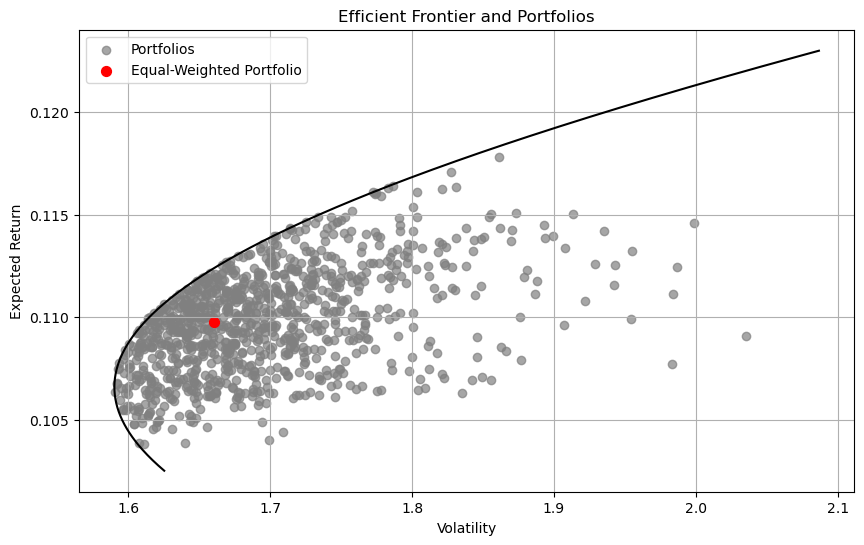

In [67]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio') 
plt.plot(sigma_P_values, mu_P_values, color='black')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()


In [48]:
# Let us check if this equation is indeed correct; for the equal-weighted portfolio's volatility

risk_e_optimal = equation(returns_e)[0][0]

print(f"The Equal-Weighted Portfolio's Returns: {returns_e}")
print(f"The Equal-Weighted Portfolio's Volatility: {risk_e}")
print(f"The Optimal Volatility: {risk_e_optimal}")

The Equal-Weighted Portfolio's Returns: 0.10978209348140466
The Equal-Weighted Portfolio's Volatility: 1.6606374013061511
The Optimal Volatility: 1.6118098306212894


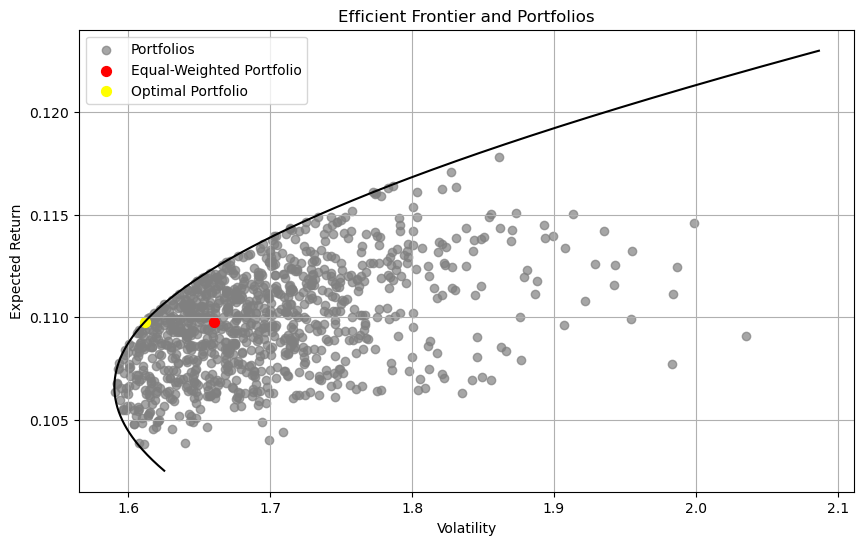

In [51]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(sigma_P_values, mu_P_values, color='black')
plt.scatter(risk_e_optimal, returns_e, color='yellow', s=50, label='Optimal Portfolio') 

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()


In [52]:
# Finally we just have to find the Minimum Variance Portfolio

display(Math(r"\mu_{P_{min}} = \frac{\pi_1}{2\pi_2}"))
display(Math(r"\sigma_{P_{min}}^2 = \pi_0 - \frac{\pi_1^2}{4\pi_2}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [54]:
# Obtain the MVP

min_returns = pi_1/(2*pi_2)
min_volat = np.sqrt(pi_0 - ((pi_1**2)/(4*pi_2)))

print(f"The MVP Returns are: {min_returns[0][0]}")
print(f"The MVP Volatility is: {min_volat[0][0]}")

The MVP Returns are: 0.10658401504250568
The MVP Volatility is: 1.5901676193927006


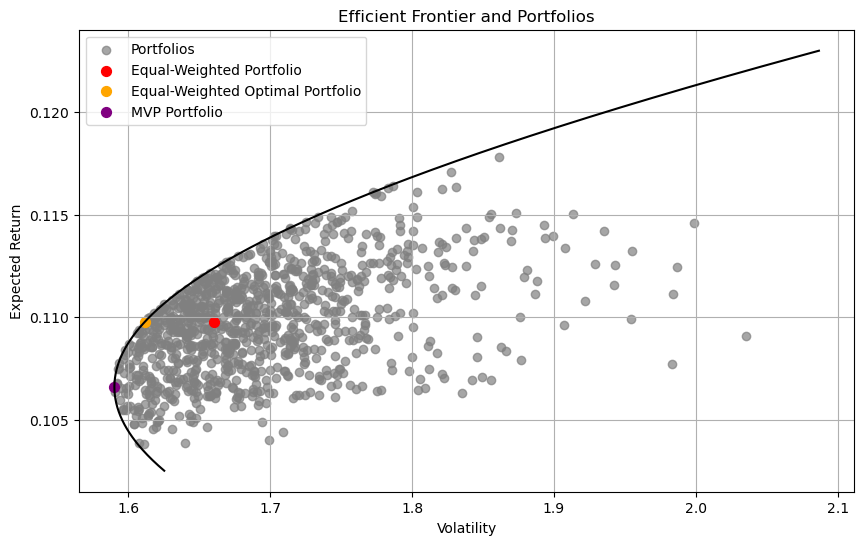

In [55]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(sigma_P_values, mu_P_values, color='black')
plt.scatter(risk_e_optimal, returns_e, color='orange', s=50, label='Equal-Weighted Optimal Portfolio') 
plt.scatter(min_volat, min_returns, color='purple', s=50, label='MVP Portfolio') 

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()